In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util

In [2]:
_N = 5
_M = 5
_NEW_VERTICES = 5

_ATTR_COUNT = _M * _N

_SURPRISE_THRESH = 1

In [3]:
# Attribute selection
def attr_count(itr):
    return _N * _M + itr

def pick_attr(vtx):
    return np.random.randint(0, attr_count(vtx.data))

In [4]:
# Time discounting
def time_discount(del_i):
    # Discount based on delta i, the number of iterations ago
    # this attribute was assigned
    return np.exp(del_i)

In [5]:
# Edge selection
def has_edge(u, v, attr_dict):
    # For vertex v len(attr_dict[v]) == v.data + 1
    attr_comp_cnt = min(u.data + 1, v.data + 1)
    longest_exist = max(u.data + 1, v.data + 1)
    
    total_surprise = 0
    for a_idx in range(attr_comp_cnt):
        discount = time_discount(longest_exist - a_idx)
        total_surprise *= attr_count(a_idx) ** -2 / discount \
            if attr_dict[u][a_idx] == attr_dict[v][a_idx] else 1
    return total_surprise >= _SURPRISE_THRESH

In [6]:
# Graph creation
def attribute_block_graph(n):
    vtx_set = []
    attr_dict = {}

    for i in range(n):
        vtx = graph.Vertex(0, 0, {0 : 0}, i)
        vtx.data = 0
        vtx_set.append(vtx)

    G = graph.Graph()
    G.vertices = vtx_set
    
    for vtx in G.vertices:
        attr_dict[vtx] = [ pick_attr(vtx) ]
    
    for u in G.vertices:
        for v in G.vertices:
            if u.vnum == v.vnum:
                continue
            if not G.are_neighbors(u, v) and has_edge(u, v, attr_dict):
                G.add_edge(u, v, 1)

    G.data = attr_dict
    return G

In [7]:
# For adding to graph
def add_attr_graph_vtx(G, v):
    v.data = 0
    G.data[v] = [ pick_attr(v) ]

    G.vertices.append(v)
    return v

def add_attr_dim(G):
    for v in G.vertices:
        v.data += 1
        G.data[v].append(pick_attr(v))
        
def recalc_edges(G):
    for uidx, u in enumerate(G.vertices):
        for vidx, v in enumerate(G.vertices):
            if uidx == vidx:
                continue
            if not G.are_neighbors(u, v) and has_edge(u, v, G.data):
                G.add_edge(u, v, 1)
            elif G.are_neighbors(u, v) and not has_edge(u, v, G.data):
                G.remove_edge(u, v)

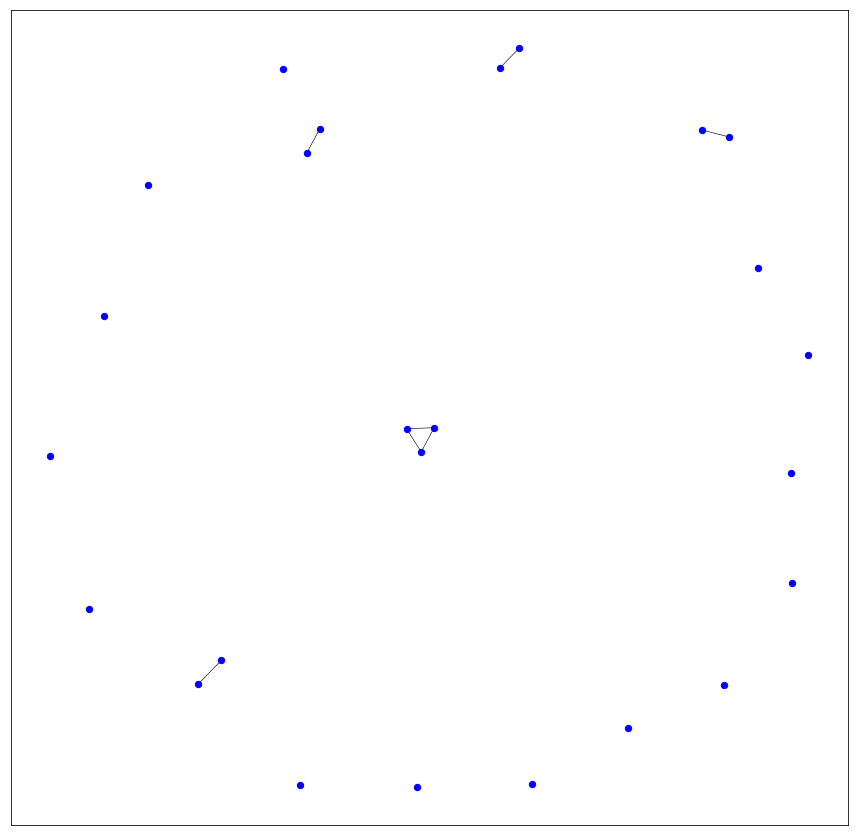

In [8]:
G_attr = attribute_block_graph(_N * _M)

G_attr_nx = gnx.graph_to_nx(G_attr)
G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
plt.figure(figsize=(15,15))
nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color='b',
                 node_size=40, width=0.6, with_labels=False)

def draw_graph(G_attr, nvtx):
    G_attr_nx = gnx.graph_to_nx(G_attr)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    
    prev_pos = G_attr_vtx_pos
    prev_nodes = G_attr_nx.nodes()
    
    # Get position of new vertex
    # Calculate positions as if all new, use this position for new vertex
    k_dist = 1 / (5 * np.sqrt(G_attr.num_people))
    G_attr_vtx_pos_recalc = nx.drawing.layout.spring_layout(G_attr_nx, k=k_dist)
    prev_pos[nvtx] = G_attr_vtx_pos_recalc[nvtx]
    
    nvtx_idx = list(G_attr_nx.nodes()).index(nvtx)
    colors = [ 'b' ] * len(G_attr.vertices)
    colors[nvtx_idx] = 'r'
    prev_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx,
                                                     pos=prev_pos, fixed=prev_nodes)
    
    # Draw graph
    plt.figure(figsize=(15,15))
    nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color=colors,
                     node_size=40, width=0.6, with_labels=None)

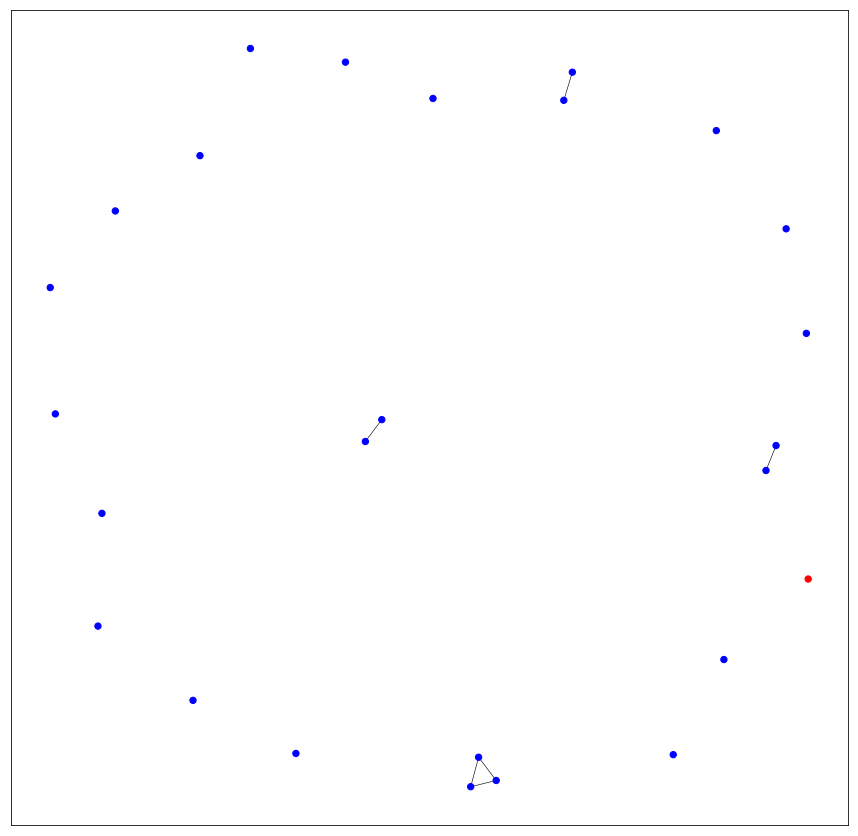

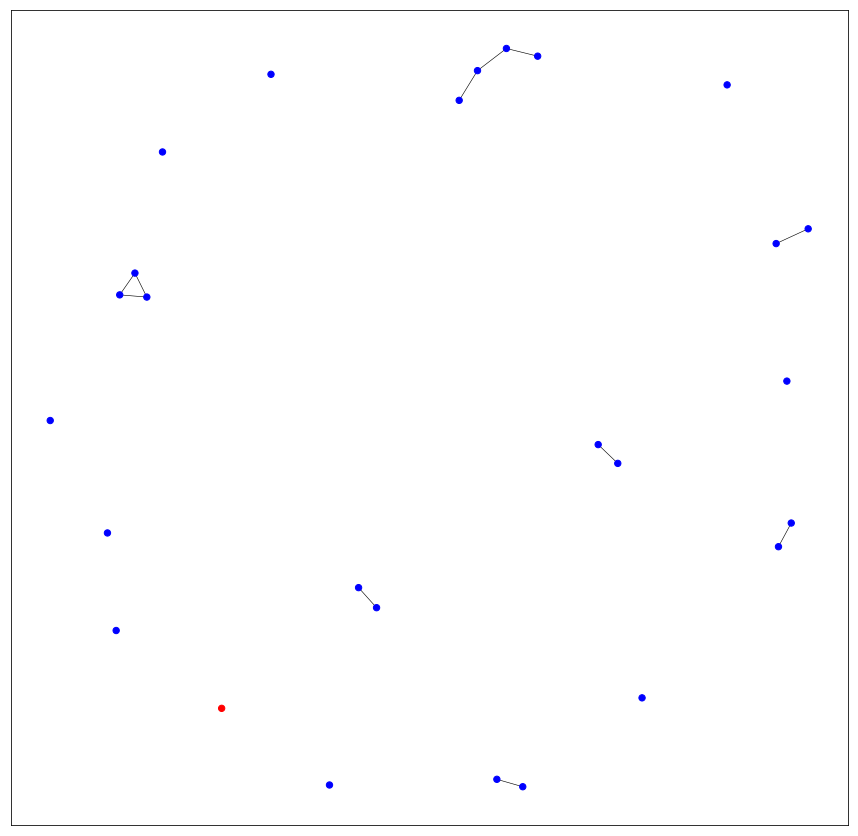

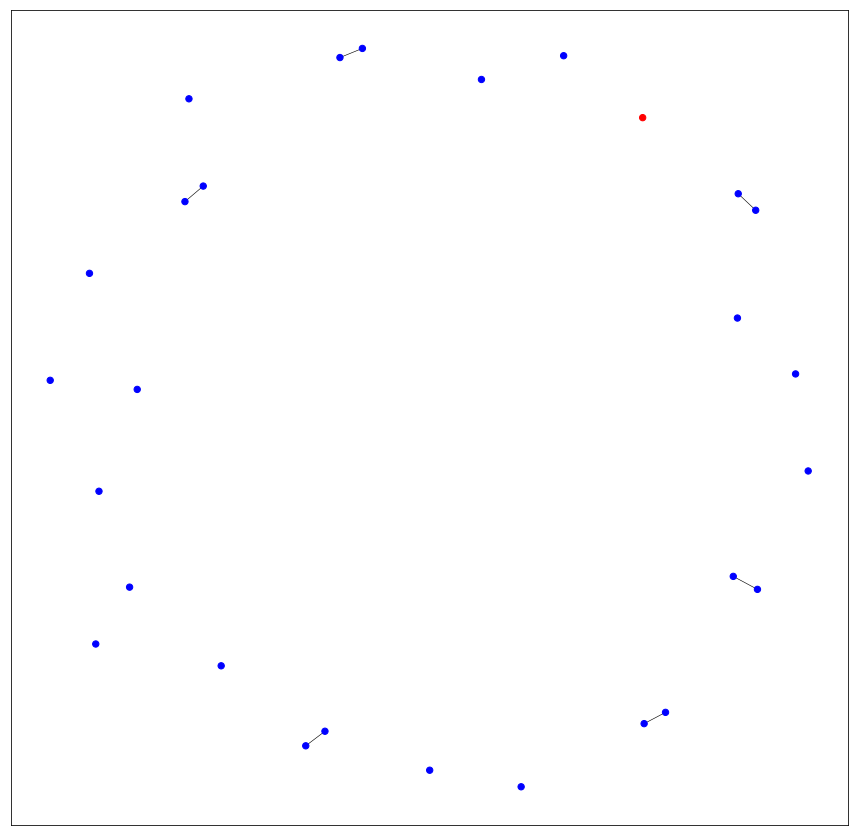

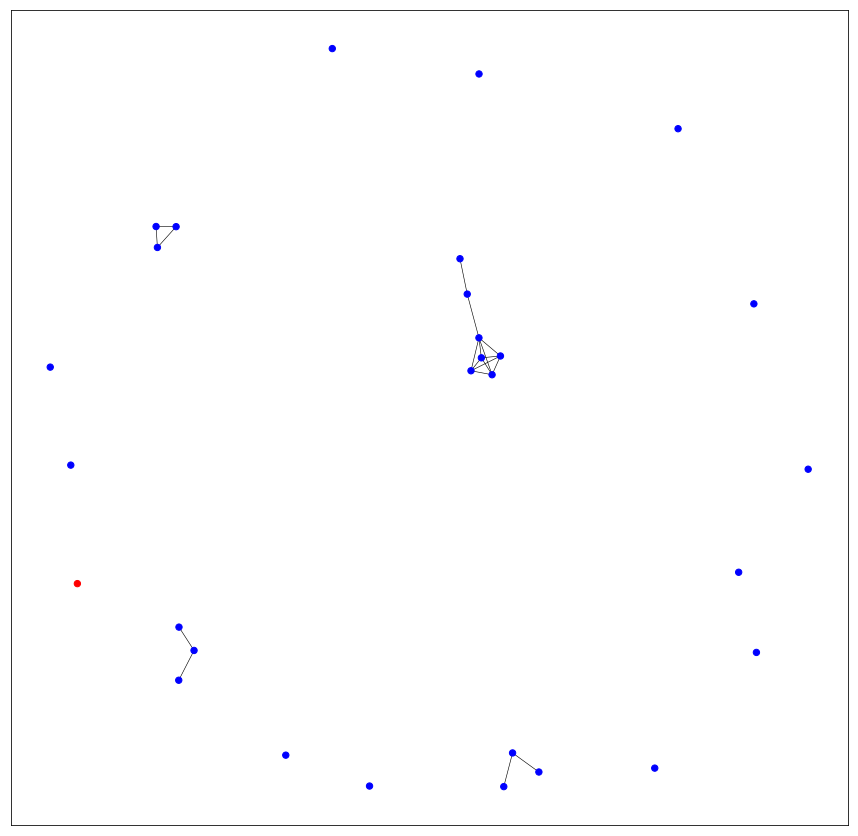

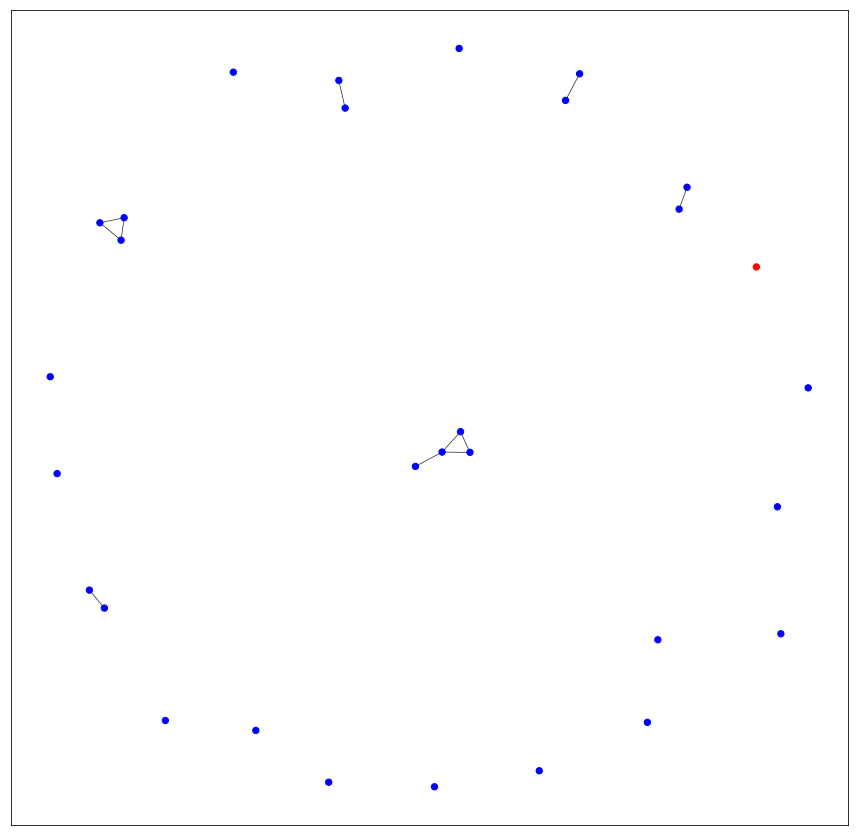

In [9]:
for itr in range(_NEW_VERTICES):
    
    # Add vertex and add dimension to attributes
    nvtx = graph.Vertex(0, 0, {0 : 0}, _N * _M + itr)
    nvtx.data = 0
    
    # Order here is quite important
    add_attr_dim(G_attr)
    add_attr_graph_vtx(G_attr, nvtx)
    recalc_edges(G_attr)
    
    draw_graph(G_attr, nvtx)